# Perbandingan Model Simple RNN vs. LSTM untuk Klasifikasi Cyberbullying
Dokumen ini merangkum hasil eksperimen dalam membangun model deep learning untuk mengklasifikasikan komentar cyberbullying dari dataset Instagram. Dua arsitektur utama yang dibandingkan adalah Simple RNN dan LSTM.

## Import library awal

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords

## Load dataset dan EDA

In [2]:
df = pd.read_excel("CYBERBULLYING INSTAGRAM.xlsx")

In [3]:
print(df.head())

                                            Komentar      Kategori
0        "Kaka tidur yaa, udah pagi, gaboleh capek2"  Non-bullying
1            "makan nasi padang aja begini badannya"  Non-bullying
2  "yang aku suka dari dia adalah selalu cukur je...      Bullying
3  "Hai kak Isyana aku ngefans banget sama kak Is...  Non-bullying
4  "Manusia apa bidadari sih herann deh cantik te...  Non-bullying


In [4]:
try:
    stopwords_indonesia = stopwords.words('indonesian')
except:
    nltk.download('stopwords')
    stopwords_indonesia = stopwords.words('indonesian')

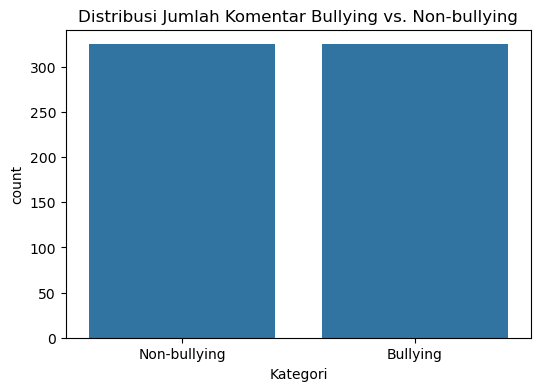

Kategori
Non-bullying    325
Bullying        325
Name: count, dtype: int64


In [5]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Kategori', data=df)
plt.title('Distribusi Jumlah Komentar Bullying vs. Non-bullying')
plt.show()
print(df['Kategori'].value_counts())

In [6]:
df['panjang_komentar'] = df['Komentar'].apply(len)
print("\n--- EDA: Statistik Panjang Komentar ---")
print(df['panjang_komentar'].describe())


--- EDA: Statistik Panjang Komentar ---
count    650.000000
mean      63.120000
std       28.414352
min       24.000000
25%       42.000000
50%       54.500000
75%       78.750000
max      173.000000
Name: panjang_komentar, dtype: float64


## Pre-Processing Data

In [7]:
def clean_text(text):
    # Mengubah ke huruf kecil
    text = text.lower()
    # Menghapus karakter spesial, angka, dan tanda baca
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    # Menghapus stopwords
    tokens = text.split()
    tokens_without_stopwords = [word for word in tokens if not word in stopwords_indonesia]
    text = " ".join(tokens_without_stopwords)
    return text

In [8]:
# pre-processing
# Membuat kolom baru untuk komentar yang sudah dibersihkan
df['Komentar_bersih'] = df['Komentar'].apply(clean_text)

# mengubah nilai kategori menjadi numerik 1 (bullying) dan 0 (non-bullying) 
map_kategori = {
    'Bullying': 1,
    'Non-bullying': 0
}

df['Kategori_encoded'] = df['Kategori'].map(map_kategori)
# Tampilkan hasil untuk verifikasi
print("--- Nilai Setelah Diubah ---")
print(df[['Kategori', 'Kategori_encoded']].head(10))

--- Nilai Setelah Diubah ---
       Kategori  Kategori_encoded
0  Non-bullying                 0
1  Non-bullying                 0
2      Bullying                 1
3  Non-bullying                 0
4  Non-bullying                 0
5      Bullying                 1
6  Non-bullying                 0
7      Bullying                 1
8      Bullying                 1
9      Bullying                 1


In [9]:
print("Teks Asli  :", df['Komentar'].iloc[5])
print("Teks Bersih:", df['Komentar_bersih'].iloc[5])

Teks Asli  : "@ayu.kinantii isyan skrg berubah ya:( baju nya nakal"
Teks Bersih: ayukinantii isyan skrg berubah ya baju nya nakal


## Import library untuk membuat Modelnya

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Embedding, LSTM, SimpleRNN, Dense, Dropout, 
                                     SpatialDropout1D)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings

In [11]:
# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(df['Komentar_bersih'].values, df['Kategori_encoded'].values, test_size=0.2, random_state=42)

In [12]:
# Tokenisasi
vocab_size = 5000
oov_token = "<OOV>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [13]:
# Padding
max_length = 50
padded_train = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
padded_test = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

In [14]:
# Membuat model
embedding_dim = 16
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    SimpleRNN(32, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
num_epochs = 20
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model.fit(
    padded_train, 
    y_train, 
    epochs=num_epochs, 
    validation_data=(padded_test, y_test), 
    callbacks=[early_stopping],
    verbose=2
)

Epoch 1/20
17/17 - 4s - 261ms/step - accuracy: 0.4788 - loss: 0.7024 - val_accuracy: 0.5000 - val_loss: 0.6911
Epoch 2/20
17/17 - 0s - 20ms/step - accuracy: 0.6365 - loss: 0.6642 - val_accuracy: 0.5923 - val_loss: 0.6753
Epoch 3/20
17/17 - 0s - 18ms/step - accuracy: 0.7923 - loss: 0.4952 - val_accuracy: 0.5538 - val_loss: 0.7397
Epoch 4/20
17/17 - 0s - 19ms/step - accuracy: 0.9135 - loss: 0.2864 - val_accuracy: 0.5692 - val_loss: 0.8627


In [16]:
# --- 7. Evaluasi dan Prediksi ---
print("\n--- Mengevaluasi Model ---")
loss, accuracy = model.evaluate(padded_test, y_test)
print(f'Akurasi Model pada Data Uji: {accuracy*100:.2f}%')


--- Mengevaluasi Model ---
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5923 - loss: 0.6753
Akurasi Model pada Data Uji: 59.23%


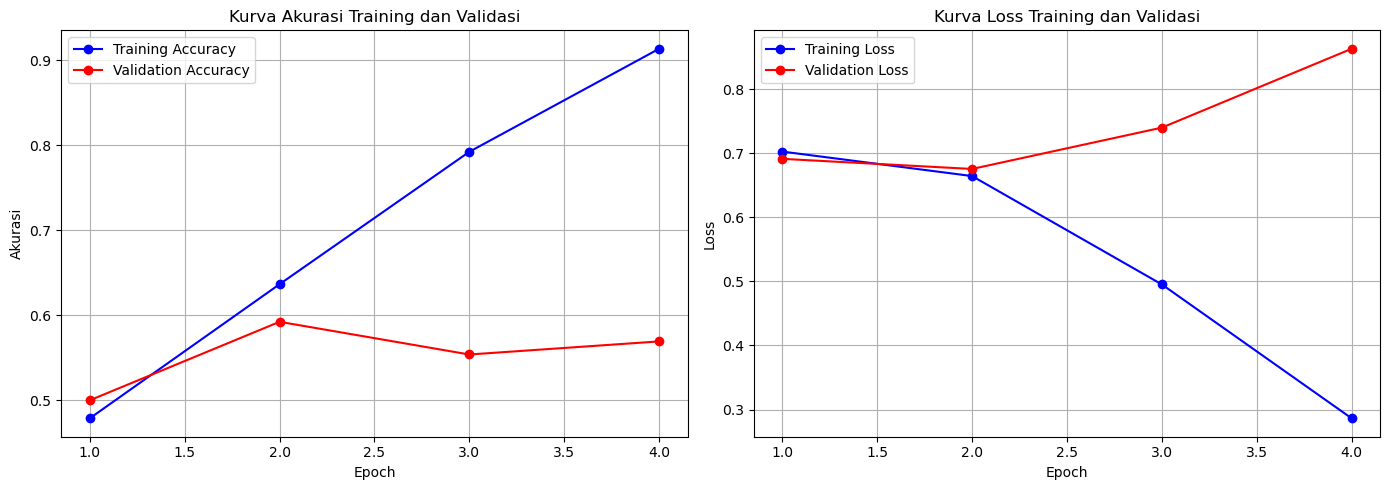

In [17]:
import matplotlib.pyplot as plt

# --- Ambil data history dari model.fit() ---
history_dict = history.history

# --- Data untuk plotting ---
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# --- Buat range epoch ---
epochs = range(1, len(acc) + 1)

# --- Buat figure dan axes untuk plot ---
plt.figure(figsize=(14, 5))

# --- Plot 1: Grafik Akurasi ---
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Kurva Akurasi Training dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

# --- Plot 2: Grafik Loss ---
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Kurva Loss Training dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- Tampilkan plot ---
plt.tight_layout()
plt.show()

In [18]:
def prediksi_cyberbullying(komentar_baru):
    # Membersihkan input baru dengan fungsi yang sama
    komentar_bersih = clean_text(komentar_baru)
    # Preprocessing (tokenize & pad)
    sekuens = tokenizer.texts_to_sequences([komentar_bersih])
    padded = pad_sequences(sekuens, maxlen=max_length, padding='post', truncating='post')
    # Prediksi
    prediksi = model.predict(padded)
    
    # Interpretasi hasil
    if prediksi[0][0] > 0.5:
        return f"Bullying ({prediksi[0][0]*100:.2f}%)" 
    else:
        return f"Non-bullying ({prediksi[0][0]*100:.2f}%)"

In [19]:
print("\n--- Mencoba Prediksi Baru ---")
print(f"Prediksi untuk 'kamu jelek sekali, tidak pantas hidup': {prediksi_cyberbullying('kamu jelek sekali, tidak pantas hidup')}")
print(f"Prediksi untuk 'keren banget, semoga sukses selalu': {prediksi_cyberbullying('keren banget, semoga sukses selalu')}")


--- Mencoba Prediksi Baru ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
Prediksi untuk 'kamu jelek sekali, tidak pantas hidup': Non-bullying (46.02%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Prediksi untuk 'keren banget, semoga sukses selalu': Non-bullying (35.41%)


## Model 1: Simple RNN (dengan Regularisasi)
Model Simple RNN dibangun dengan menggunakan teknik regularisasi Dropout(0.5) dan EarlyStopping untuk mencegah overfitting.

* Perilaku Training: Model mulai overfitting sangat cepat. EarlyStopping bekerja dengan benar dan menghentikan proses training di Epoch 4 untuk mencegah performa menjadi lebih buruk.
* Akurasi Final pada Data Uji: 59.23%

### Kesimpulan Simple RNN:
Meskipun sudah menggunakan teknik regularisasi, model Simple RNN tidak berhasil mempelajari pola pada dataset ini secara efektif. Performanya tidak lebih baik dari tebakan acak dan tidak dapat diandalkan untuk tugas ini.

# LSTM

## Import LSTM

In [20]:
from tensorflow.keras.layers import LSTM

In [28]:
# --- Membangun Model LSTM ---
embedding_dim = 16
max_length = 50
vocab_size = 5000

lstm_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(32, return_sequences=False),  # Menggunakan layer LSTM
    Dense(1, activation='sigmoid')
])

# Kompilasi model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# Menampilkan ringkasan model
lstm_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
# --- Melatih Model LSTM ---
num_epochs = 10
history_lstm = lstm_model.fit(
    padded_train, 
    y_train, 
    epochs=num_epochs, 
    validation_data=(padded_test, y_test),
    verbose=2
)

Epoch 1/10
17/17 - 5s - 290ms/step - accuracy: 0.4942 - loss: 0.6937 - val_accuracy: 0.4769 - val_loss: 0.6935
Epoch 2/10
17/17 - 1s - 30ms/step - accuracy: 0.5058 - loss: 0.6933 - val_accuracy: 0.4769 - val_loss: 0.6936
Epoch 3/10
17/17 - 0s - 28ms/step - accuracy: 0.5058 - loss: 0.6932 - val_accuracy: 0.4769 - val_loss: 0.6933
Epoch 4/10
17/17 - 0s - 29ms/step - accuracy: 0.5058 - loss: 0.6932 - val_accuracy: 0.4769 - val_loss: 0.6933
Epoch 5/10
17/17 - 0s - 28ms/step - accuracy: 0.5058 - loss: 0.6933 - val_accuracy: 0.4769 - val_loss: 0.6939
Epoch 6/10
17/17 - 1s - 29ms/step - accuracy: 0.5058 - loss: 0.6941 - val_accuracy: 0.4769 - val_loss: 0.6952
Epoch 7/10
17/17 - 0s - 29ms/step - accuracy: 0.5058 - loss: 0.6934 - val_accuracy: 0.4769 - val_loss: 0.6943
Epoch 8/10
17/17 - 1s - 31ms/step - accuracy: 0.5058 - loss: 0.6932 - val_accuracy: 0.4769 - val_loss: 0.6940
Epoch 9/10
17/17 - 1s - 33ms/step - accuracy: 0.5135 - loss: 0.6886 - val_accuracy: 0.6000 - val_loss: 0.6474
Epoch 10/

In [30]:
# --- Mengevaluasi Model LSTM ---
print("\n--- Mengevaluasi Model LSTM ---")
loss_lstm, accuracy_lstm = lstm_model.evaluate(padded_test, y_test)
print(f'Akurasi Model LSTM pada Data Uji: {accuracy_lstm*100:.2f}%')


--- Mengevaluasi Model LSTM ---
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8231 - loss: 0.5182
Akurasi Model LSTM pada Data Uji: 82.31%


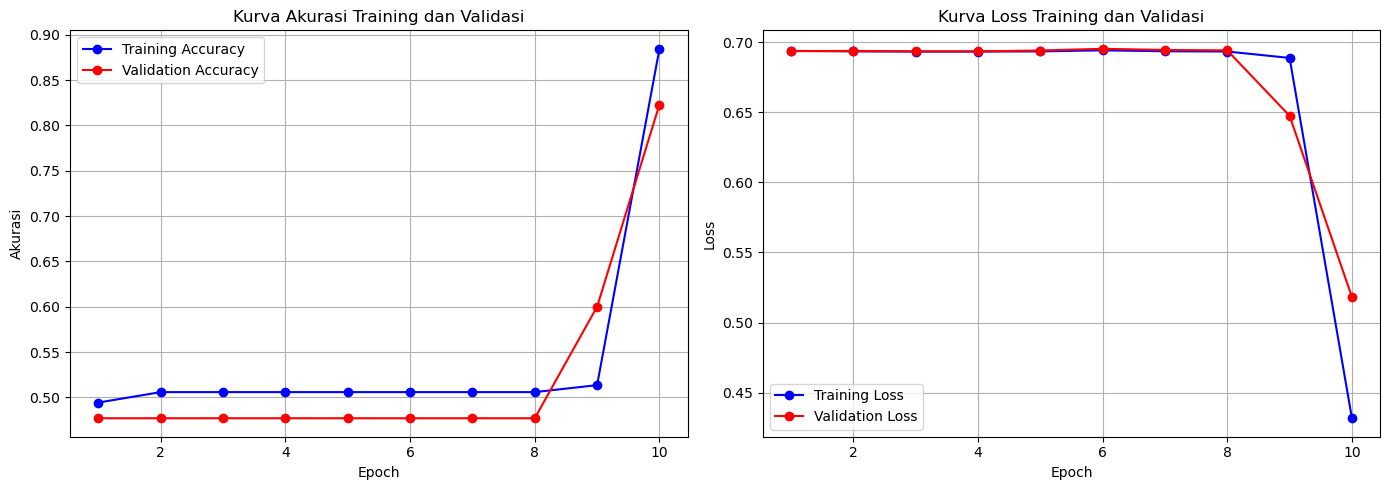

In [34]:
# --- Ambil data history dari model.fit() ---
history_dict = history_lstm.history

# --- Data untuk plotting ---
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# --- Buat range epoch ---
epochs = range(1, len(acc) + 1)

# --- Buat figure dan axes untuk plot ---
plt.figure(figsize=(14, 5))

# --- Plot 1: Grafik Akurasi ---
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Kurva Akurasi Training dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

# --- Plot 2: Grafik Loss ---
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Kurva Loss Training dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- Tampilkan plot ---
plt.tight_layout()
plt.show()

In [31]:
def prediksi_cyberbullying_lstm(komentar_baru):
    # Membersihkan dan memproses teks input
    komentar_bersih = clean_text(komentar_baru)
    sekuens = tokenizer.texts_to_sequences([komentar_bersih])
    padded = pad_sequences(sekuens, maxlen=max_length, padding='post', truncating='post')
    
    # Melakukan prediksi dengan model LSTM
    prediksi = lstm_model.predict(padded)
    
    # Menginterpretasikan hasil prediksi
    if prediksi[0][0] > 0.5:
        return f"Bullying ({prediksi[0][0]*100:.2f}%)" 
    else:
        return f"Non-bullying ({prediksi[0][0]*100:.2f}%)"

In [32]:
# --- Mencoba Prediksi Baru dengan LSTM ---
print("\n--- Mencoba Prediksi Baru dengan Model LSTM ---")
print(f"Prediksi untuk 'kamu jelek sekali, tidak pantas hidup': {prediksi_cyberbullying_lstm('kamu jelek sekali, tidak pantas hidup')}")
print(f"Prediksi untuk 'keren banget, semoga sukses selalu': {prediksi_cyberbullying_lstm('keren banget, semoga sukses selalu')}")


--- Mencoba Prediksi Baru dengan Model LSTM ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
Prediksi untuk 'kamu jelek sekali, tidak pantas hidup': Bullying (96.40%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Prediksi untuk 'keren banget, semoga sukses selalu': Non-bullying (21.68%)


In [33]:
print(f"Prediksi untuk 'kamu jelek sekali, tidak pantas hidup': {prediksi_cyberbullying_lstm('jelek')}")
print(f"Prediksi untuk 'keren banget, semoga sukses selalu': {prediksi_cyberbullying_lstm('semangat')}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Prediksi untuk 'kamu jelek sekali, tidak pantas hidup': Bullying (96.39%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Prediksi untuk 'keren banget, semoga sukses selalu': Non-bullying (21.69%)


## Model 2: LSTM (Dasar)
Model LSTM yang dibangun adalah model dasar tanpa Dropout atau EarlyStopping dan dilatih selama 10 epoch.

* Perilaku Training: Meskipun pada awalnya proses belajar berjalan lambat, model berhasil menemukan pola pada data di epoch-epoch akhir, yang ditandai dengan peningkatan akurasi dan penurunan loss yang signifikan.
* Akurasi Final pada Data Uji: 82.31%

## Kesimpulan LSTM:
Bahkan dalam bentuk dasarnya, model LSTM berhasil dengan sangat baik. Ia mampu mempelajari dataset secara efektif dan memberikan akurasi yang tinggi dan dapat diandalkan.

## Hasil Akhir
| Model | Akurasi Akhir | Catatan Kinerja |
| :--- | :--- | :--- |
| Simple RNN (dengan Regularisasi) | 59.23% | **Tidak berhasil**. Model *overfitting* sangat cepat. |
| **LSTM (Dasar)** | **82.31%** | **Berhasil**. Performa jauh lebih unggul dan stabil. |

## Analisis Final
Perbandingan ini secara definitif menunjukkan bahwa untuk masalah klasifikasi komentar cyberbullying pada dataset Anda, arsitektur LSTM jauh lebih superior daripada Simple RNN. Model LSTM mampu menangkap kompleksitas bahasa dan konteks yang gagal dipelajari oleh Simple RNN.

## Rekomendasi
Fokus selanjutnya adalah mengoptimalkan model LSTM. Dengan menerapkan Dropout dan EarlyStopping pada model LSTM yang sudah terbukti berhasil ini, Anda memiliki potensi untuk meningkatkan akurasi lebih jauh lagi di atas 82.31%.